In [1]:
import os
import sys
import time
import shutil
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import f1_score
from tensorflow import keras


import sklearn.preprocessing

2024-09-14 07:43:22.205849: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-14 07:43:22.358364: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 07:43:22.358458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 07:43:22.403008: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 07:43:22.493611: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Set your memory limit here
    except RuntimeError as e:
        print(e)

2024-09-14 07:43:25.763999: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 07:43:25.925772: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 07:43:25.925826: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
def get_dataset(directory, single_file=False, use_half=False, section=1, use_num_files=False, num_files=100):  
    if single_file:
        df = pd.read_csv(directory, index_col='timestamp')
        df.dropna(inplace=True)
        return df
    
    merged_df = pd.DataFrame()
    list_files = os.listdir(directory)
    print(len(list_files))
    if use_num_files:
        for i in range(num_files):
            df = pd.read_csv(os.path.join(directory, list_files[i]), index_col='timestamp')
            df.dropna(inplace=True)
            merged_df = pd.concat([merged_df, df], ignore_index=True)

    if use_half:
        for i, files in enumerate(list_files):
            if section==1:
                if i > len(list_files) //2:
                    continue
                df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
                df.dropna(inplace=True)
                merged_df = pd.concat([merged_df, df], ignore_index=True)
            if section==2:
                if i <= len(list_files) // 2:
                    continue
                df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
                df.dropna(inplace=True)
                merged_df = pd.concat([merged_df, df], ignore_index=True)
    else:
        for files in list_files:
            df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
            df.dropna(inplace=True)
            merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    # print(i)
    return merged_df

In [4]:
def convert_time_window(data, timesteps):
    samples = data.shape[0] - timesteps + 1  # Number of samples in the new 3D array
    variables = data.shape[1]  # Number of variables (features)

    data_3d = np.zeros((samples, timesteps, variables), dtype='float16')

    for i in range(samples):
        data_3d[i] = data[i:i+timesteps]
    return data_3d

In [5]:
def inverse_convert_time_window(data_3d):
    samples, timesteps, variables = data_3d.shape
    data_2d = np.zeros((samples + timesteps - 1, variables))

    count = np.zeros((samples + timesteps - 1, variables))

    for i in range(samples):
        data_2d[i:i+timesteps] += data_3d[i]
        count[i:i+timesteps] += 1

    # Average the overlapping segments
    data_2d /= count
    return data_2d

In [6]:
def calculate_time_shift(df, variable, gamma=0.9, label_col='class'):
    min_val = df[variable].min()
    max_val = df[variable].max()
    df['normalized_var'] = (df[variable] - min_val) / (max_val - min_val)

    threshold_value = gamma
    shift_index = df.index[df['normalized_var'] >= threshold_value][0]

    df_shifted = df.copy()
    df_shifted[label_col] = 0 
    df_shifted.loc[shift_index:, label_col] = 1

    df_shifted.drop(columns=['normalized_var'], inplace=True)
    df.drop(columns=['normalized_var'], inplace=True)

    return df_shifted

In [7]:
def calculate_reconstruction_loss(data, reconstructions):
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    return reconstruction_errors

In [120]:
def find_optimal_threshold(reconstruction_errors, y_true, num_steps=500):
    # Initialize variables
    best_f1 = 0
    best_upper_threshold = 0
    best_lower_threshold = 0
    best_y_pred = None
    
    # Calculate median, mean, and max of reconstruction errors
    q1 = np.percentile(reconstruction_errors, 25)
    q3 = np.percentile(reconstruction_errors, 75)
    max_error = np.max(reconstruction_errors)
    min_error = -1 * max_error
    
    # Define search ranges for upper and lower thresholds
    upper_search_range = np.linspace(q3, max_error, num=num_steps)
    lower_search_range = np.linspace(q1, min_error, num=num_steps)
    
    # Iterate over both thresholds in parallel
    for upper_threshold, lower_threshold in zip(upper_search_range, lower_search_range):
        if upper_threshold > lower_threshold:  # Ensure valid threshold combination
            # Get y_pred based on the current thresholds
            y_pred = np.where((reconstruction_errors > upper_threshold) | (reconstruction_errors < lower_threshold), 1, 0)
            
            # Calculate F1-score
            current_f1 = f1_score(y_true.astype(bool), y_pred.astype(bool))
            
            # Update if a better F1-score is found
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_upper_threshold = upper_threshold
                best_lower_threshold = lower_threshold
                best_y_pred = y_pred

    threshold_range = best_upper_threshold - best_lower_threshold
    # Iterate over possible starting points for the lower threshold
    for lower_threshold in np.linspace(min_error, max_error - threshold_range, num=num_steps):
        upper_threshold = lower_threshold + threshold_range

        if upper_threshold > max_error:  # Ensure valid upper threshold
            break

        # Generate predictions for the current threshold range
        y_pred = np.where((reconstruction_errors > upper_threshold) | (reconstruction_errors < lower_threshold), 1, 0)

        # Calculate F1-score
        current_f1 = f1_score(y_true.astype(bool), y_pred.astype(bool))

        # Update if a better F1-score is found
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_upper_threshold = upper_threshold
            best_lower_threshold = lower_threshold
            best_y_pred = y_pred

    return best_upper_threshold, best_lower_threshold, best_f1, best_y_pred


In [9]:
# def find_optimal_threshold(reconstruction_errors, y_true):
#     best_threshold = 0.0
#     best_f1 = 0.0
#     best_y_pred = np.zeros(reconstruction_errors.shape)

#     thresholds = np.linspace(0.0, 1.0, num=1000)

#     for threshold in thresholds:
#         y_pred = (reconstruction_errors > threshold).astype(bool)
#         # print(y_pred.shape)
#         # print(y_true.shape)

#         # Hitung F1-Score
#         current_f1 = f1_score(y_true.astype(bool), y_pred)

#         if current_f1 > best_f1:
#             best_f1 = current_f1
#             best_threshold = threshold
#             best_y_pred = y_pred

#     return best_threshold, best_f1, best_y_pred

In [10]:
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

def visualize_instance(source):
    df = pd.read_csv(source, index_col='timestamp')
    df_class = df[['class']]
    class_type = df['class'].unique()

    for col in df.columns:
        scaler = MinMaxScaler()
        scaler.fit(df[col].values.reshape(-1, 1))
        df[col] = scaler.transform(df[col].values.reshape(-1, 1))
    
    legends = list(df.columns)
    legends.extend(['normal','transient', 'fault'])

    plt.figure(figsize=(16, 8))    
    # plt.plot(df)
    # plt.xlabel('timestamp')
    # plt.ylabel('scaled')
    df.plot(figsize=(16, 8))

    xmin, xmax, ymin, ymax = plt.axis()
    
    colors = ['green', 'yellow', 'red']
    for i in range(len(class_type)):
        plt.fill_between(df.index, ymax, where=(df_class['class'] == class_type[i]), color=colors[i], alpha=0.3)
    # plt.fill_between(df.index, ymax, where=(i_class['class'] == class_type[1]), color='red', alpha=0.3)
    # plt.fill_between(df.index, ymax, where=(i_class['class'] == class_type[2]), color='yellow', alpha=0.3)
    plt.legend(legends)
    plt.grid()
    plt.title(f"{os.path.split(source)[0]}-{os.path.split(source)[1]}")
    plt.show()

In [11]:
# dff = pd.read_csv("dataset_processed/csv/8/SIMULATED_00012.csv", index_col='timestamp')
# dff['class'] = dff[['class']].applymap(lambda x: 0 if x == 0 else 1)
# dff_shifted = calculate_time_shift(dff, 'P-PDG')

In [11]:
# plt.figure(figsize=(13,7))
# plt.plot(dff['class'].values)
# plt.plot(dff_shifted['class'].values)
# plt.show()

### Training

In [12]:
dataset_dir = "../../datasets/3W/dataset_processed/splitted/2/train"

list_files = os.listdir(dataset_dir)
file_count = 100

merged_df = pd.DataFrame()


for i in range(len(list_files)):
    # if i <= file_count:
    #     continue
    df = pd.read_csv(os.path.join(dataset_dir, list_files[i]), index_col='timestamp')
    # if ['P-ANULAR','P-TPT','T-TPT','class'] == list(df.columns):
    print(df.columns)
    df.columns = ['C1', 'C2', 'C3', 'class']
    merged_df = pd.concat([merged_df, df], ignore_index=True)
    print(list_files[i])
    # if i >= file_count * 2:
    #     break

Index(['P-ANULAR', 'P-TPT', 'T-TPT', 'class'], dtype='object')
WELL-00011_20140726165720.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
SIMULATED_00012.csv
Index(['ESTADO-SDV-GL', 'ESTADO-SDV-P', 'T-TPT', 'class'], dtype='object')
WELL-00010_20171218180131.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
WELL-00011_20140823230118.csv
Index(['P-ANULAR', 'P-TPT', 'T-TPT', 'class'], dtype='object')
WELL-00013_20170329010229.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
SIMULATED_00004.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
WELL-00011_20141006150121.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
WELL-00011_20140929210121.csv
Index(['P-ANULAR', 'P-TPT', 'T-TPT', 'class'], dtype='object')
WELL-00011_20140720110102.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
SIMULATED_00015.csv
Index(['P-PDG', 'P-TPT', 'T-TPT', 'class'], dtype='object')
SIMULATED_00014.csv
Index(['P-PDG', 'P-TPT', '

In [13]:
# merged_df = get_dataset('../../datasets/3W/dataset_processed/splitted/0/train')
merged_data_class = merged_df['class']

merged_data_np = merged_df.drop('class', axis=1).values

In [14]:
scaler = pickle.load(open('StandardScaler-3W-2.pkl', 'rb'))

merged_data_np_scaled = scaler.transform(merged_data_np)

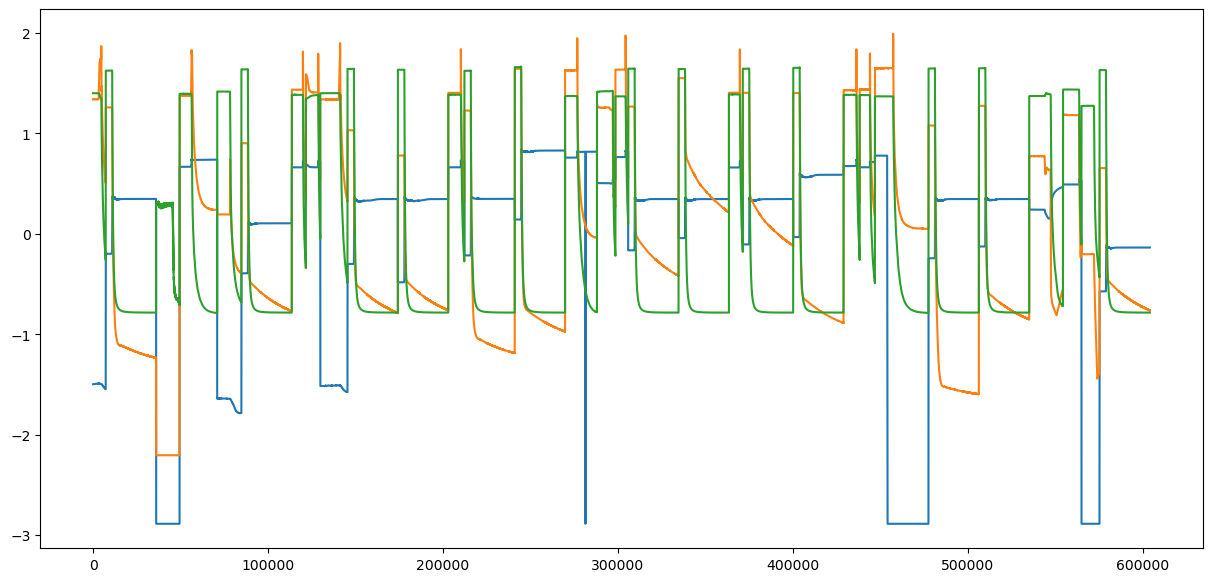

In [15]:
plt.figure(figsize=(15,7))
plt.plot(merged_data_np_scaled)
plt.show()

In [ ]:
# scaler = sklearn.preprocessing.StandardScaler()
# scaler.fit(merged_data_np)

# merged_data_np_scaled = scaler.transform(merged_data_np)

# pickle.dump(scaler, open('StandardScaler-3W-2.pkl', 'wb'))

In [16]:
# merged_data_np_3d = convert_time_window(merged_data_np_scaled, 10)
merged_data_np_3d = convert_time_window(merged_data_np_scaled, 10)

In [17]:
merged_data_np_3d.dtype

dtype('float16')

In [ ]:
tf_dataset_path = "../../datasets/3W/dataset_processed/tf_data/train/2"

dataset = tf.data.Dataset.from_tensor_slices((merged_data_np_3d, merged_data_np_3d))
dataset = dataset.batch(128)
tf.data.Dataset.save(dataset, tf_dataset_path)

### =========================================================

In [12]:
def create_lstm_autoencoder(timesteps, n_features):
    input_layer = keras.layers.Input(shape=(timesteps, n_features))
    encoder = keras.layers.LSTM(64, return_sequences=True)(input_layer)
    encoder = keras.layers.LSTM(32, return_sequences=False)(encoder)

    decoder = keras.layers.RepeatVector(timesteps)(encoder)
    decoder = keras.layers.LSTM(32, return_sequences=True)(decoder)
    decoder = keras.layers.LSTM(64, return_sequences=True)(decoder)
    output_layer = keras.layers.TimeDistributed(keras.layers.Dense(n_features))(decoder)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer, name="LSTM-Autoencoder")
    return model

In [ ]:
# To create new model
lstm_model = create_lstm_autoencoder(10, 3)
lstm_model.summary()

In [12]:
# To re-train model
lstm_model = tf.keras.models.load_model("../../logs/3W/train-1/101-200/best_model.h5")
lstm_model.summary()

2024-09-14 06:06:25.346771: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 06:06:25.346878: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 06:06:25.346902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 06:06:26.832766: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 06:06:26.832814: I tensorflow/core/common_runtime/gpu/gpu

Model: "LSTM-Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 32)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 10, 64)            24832     
                                                  

In [14]:
# To use available dataset
tf_dataset_path = "../../datasets/3W/dataset_processed/tf_data/train/2"
dataset = tf.data.Dataset.load(tf_dataset_path)

In [15]:
def myCallbacks(log_dir):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    mode='min')
    model_path = os.path.join(log_dir,'best_model.h5')
    mc = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='loss', mode='min', verbose=1, save_best_only=True)
    return [tensorboard_callback, early_stopping, mc]

In [16]:
lstm_model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['acc'])

In [17]:
log_dir = "../../logs/3W/train-1/2/"

In [18]:
history = lstm_model.fit(dataset, callbacks=myCallbacks(log_dir=log_dir), epochs=20)

Epoch 1/20


2024-09-14 06:07:55.903835: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-09-14 06:07:56.396621: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcd8408bf60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-14 06:07:56.396660: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA T500, Compute Capability 7.5
2024-09-14 06:07:56.409224: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1726268876.506059    5861 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4718/4720 [============================>.] - ETA: 0s - loss: 0.0872 - acc: 0.8685
Epoch 1: loss improved from inf to 0.08715, saving model to ../../logs/3W/train-1/2/best_model.h5
4720/4720 [==============================] - 87s 18ms/step - loss: 0.0871 - acc: 0.8685
Epoch 2/20
4719/4720 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9341
Epoch 2: loss improved from 0.08715 to 0.01910, saving model to ../../logs/3W/train-1/2/best_model.h5
4720/4720 [==============================] - 91s 19ms/step - loss: 0.0191 - acc: 0.9341
Epoch 3/20
4720/4720 [==============================] - ETA: 0s - loss: 0.0089 - acc: 0.9550
Epoch 3: loss improved from 0.01910 to 0.00891, saving model to ../../logs/3W/train-1/2/best_model.h5
4720/4720 [==============================] - 92s 19ms/step - loss: 0.0089 - acc: 0.9550
Epoch 4/20
4720/4720 [==============================] - ETA: 0s - loss: 0.0068 - acc: 0.9644
Epoch 4: loss improved from 0.00891 to 0.00681, saving model to ../../log

### Testing

In [100]:
dataset_dir = "../../datasets/3W/dataset_processed/splitted/2/test"

list_files = os.listdir(dataset_dir)
file_count = 2

merged_df_test = pd.DataFrame()


for i in range(file_count):
    df = pd.read_csv(os.path.join(dataset_dir, list_files[i]), index_col='timestamp')
    # if ['P-ANULAR','P-TPT','T-TPT','class'] == list(df.columns):
    merged_df_test = pd.concat([merged_df_test, df], ignore_index=True)
    # if i >= 100:
    #     break

In [26]:
# dataset_dir = "../../datasets/3W/dataset_processed/splitted/0/test"

# list_files = os.listdir(dataset_dir)
# # file_used = 

# merged_df_test = pd.DataFrame(columns=['C1','C2','C3','class'])

# for i in list_files:
#     df = pd.read_csv(os.path.join(dataset_dir, i), index_col='timestamp')
#     df.columns = ['C1','C2','C3','class']
#     merged_df_test = pd.concat([merged_df_test, df], ignore_index=True)

In [101]:
merged_data_test_class = merged_df_test['class']

merged_data_test_np = merged_df_test.drop('class', axis=1).values

In [102]:
scaler_test = pickle.load(open('StandardScaler-3W-2.pkl', 'rb'))
merged_data_test_np_scaled = scaler_test.transform(merged_data_test_np)
merged_data_test_np_3d = convert_time_window(merged_data_test_np_scaled, 10)

In [103]:
merged_data_test_np_3d.dtype

dtype('float16')

In [104]:
lstm_model = keras.models.load_model("../../logs/3W/train-1/2/best_model.h5")

pred_3d_np = lstm_model.predict(merged_data_test_np_3d)

1239/1239 [==============================] - 7s 5ms/step


In [105]:
pred_2d = inverse_convert_time_window(pred_3d_np)

In [106]:
pred_2d_inv = scaler_test.inverse_transform(pred_2d)

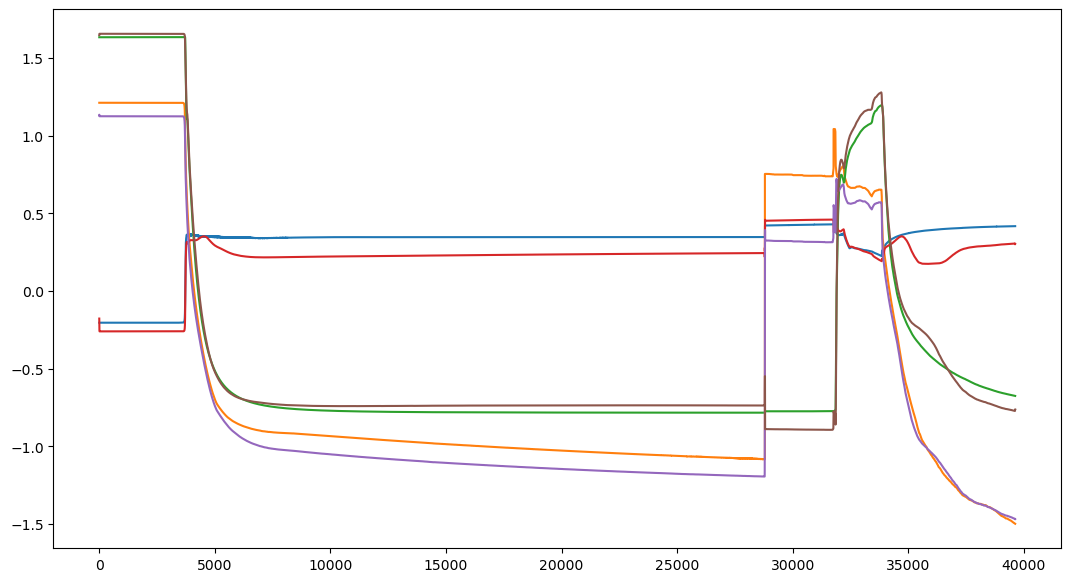

In [107]:
plt.figure(figsize=(13,7))
plt.plot(merged_data_test_np_scaled)
plt.plot(pred_2d)
# plt.legend(['C1','C2','C3','C1-rec','C2-rec','C3-rec',])
plt.show()

In [118]:
r_e = calculate_reconstruction_loss(merged_data_test_np_scaled, pred_2d)

In [16]:
# y_pred = (r_e > 0.004).astype(int)

In [121]:
thres_up, thres_down, f1, y_pred = find_optimal_threshold(r_e, np.array(merged_data_test_class))
print(thres_up, thres_down, f1)

0.19251523185636393 0.17233891779935473 0.9163075191421928


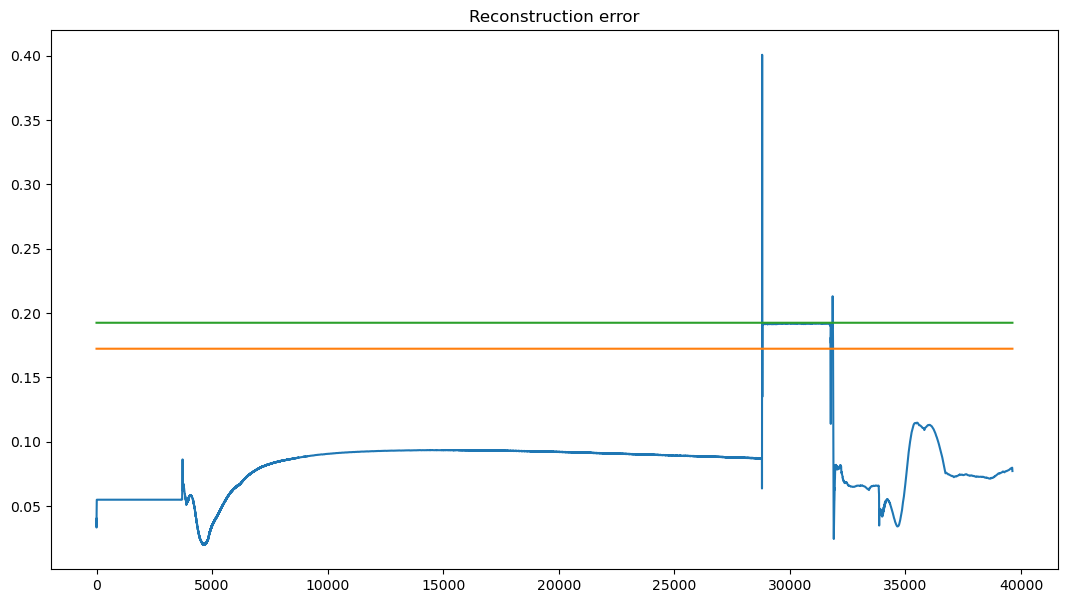

In [122]:
# iqr = np.percentile(r_e, 75) - np.percentile(r_e, 25)

plt.figure(figsize=(13,7))
plt.plot(r_e)
# plt.plot(np.full(r_e.shape[0], thres))
plt.plot(np.full(r_e.shape[0], thres_down))
plt.plot(np.full(r_e.shape[0], thres_up))
plt.title("Reconstruction error")
# plt.legend(["reconstruction error", "threshold"])
plt.show()

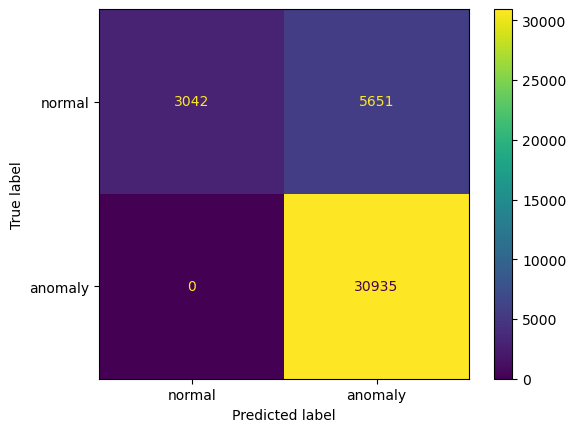

In [123]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(np.array(merged_data_test_class).astype(bool), y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'anomaly'])
cm_display.plot()

### Smaller size sample testing

In [124]:
sample_test = pd.read_csv('../../datasets/3W/dataset_processed/csv/2/WELL-00011_20141006150121.csv', index_col='timestamp')
sample_test.dropna(inplace=True)

sample_test_class = sample_test['class']
sample_test_np = sample_test.drop('class',axis=1).values

<Axes: xlabel='timestamp'>

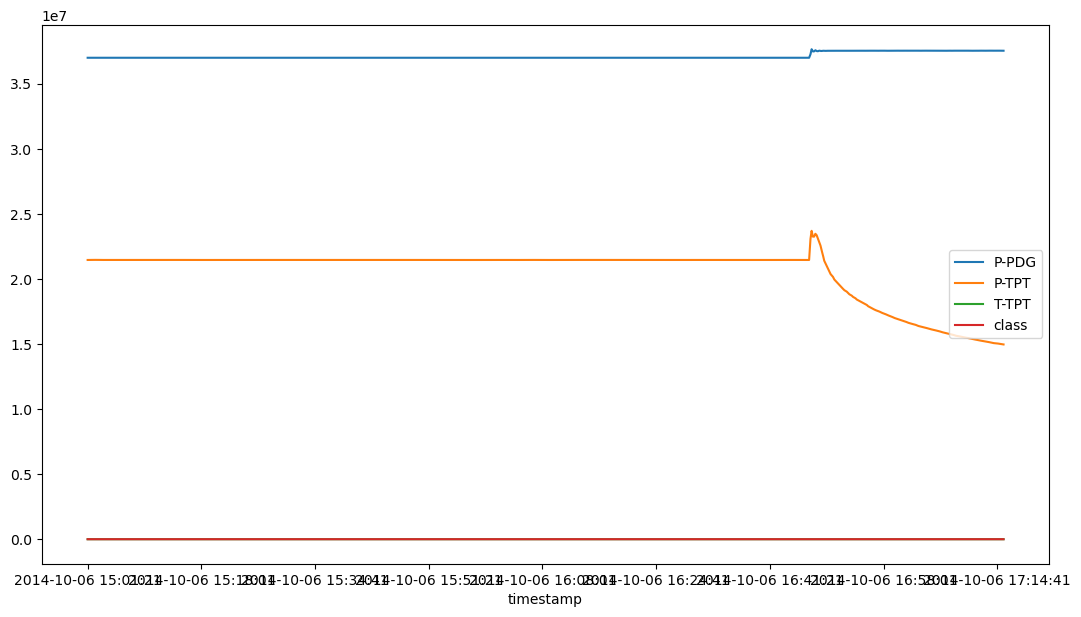

In [125]:
sample_test.plot(figsize=(13,7))

In [126]:
scaler_test = pickle.load(open('StandardScaler-3W-2.pkl', 'rb'))
sample_test_np_scaled = scaler_test.transform(sample_test_np)
sample_test_np_3d = convert_time_window(sample_test_np_scaled, 10)

In [127]:
lstm_model = keras.models.load_model("../../logs/3W/train-1/2/best_model.h5")

pred_3d_np = lstm_model.predict(sample_test_np_3d)

252/252 [==============================] - 2s 6ms/step


In [128]:
pred_2d = inverse_convert_time_window(pred_3d_np)

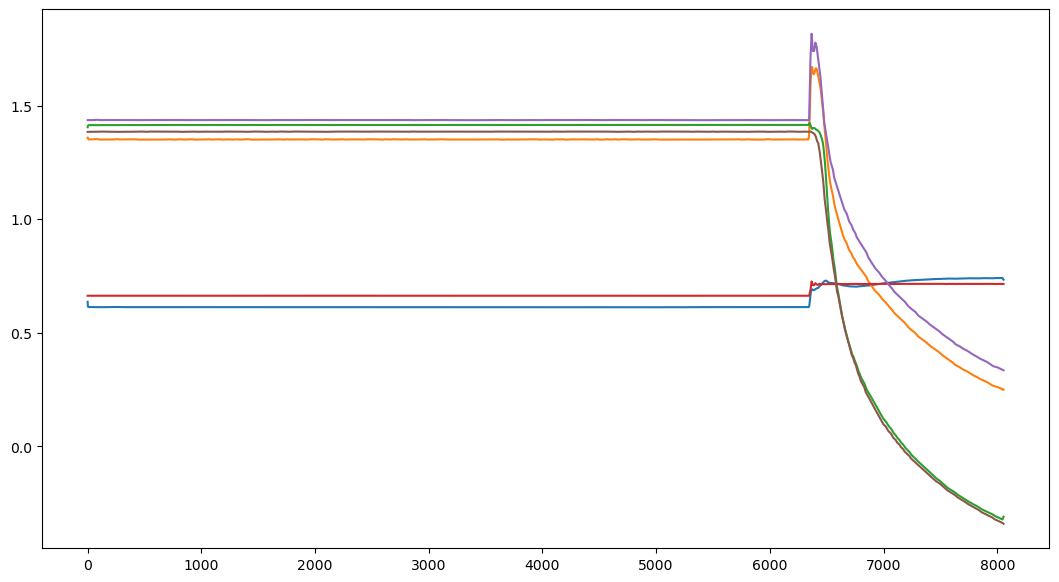

In [129]:
plt.figure(figsize=(13,7))
plt.plot(pred_2d)
plt.plot(sample_test_np_scaled)
plt.show()

In [130]:
r_e = calculate_reconstruction_loss(sample_test_np_scaled, pred_2d)

In [131]:
thres_up, thres_down, f1, sample_y_pred  = find_optimal_threshold(r_e, sample_test_class)
print(thres_up, thres_down, f1)

0.056488629809793245 0.05445857782170871 0.979214780600462


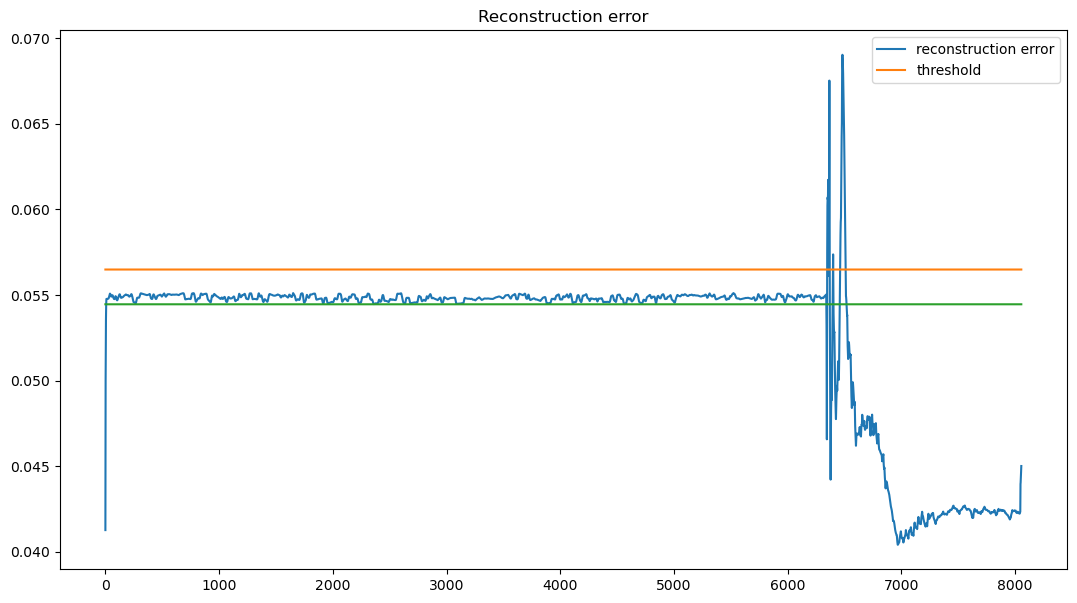

In [132]:
plt.figure(figsize=(13,7))
plt.plot(r_e)
plt.plot(np.full(r_e.shape[0], thres_up))
plt.plot(np.full(r_e.shape[0], thres_down))
plt.title("Reconstruction error")
plt.legend(["reconstruction error", "threshold"])
plt.show()

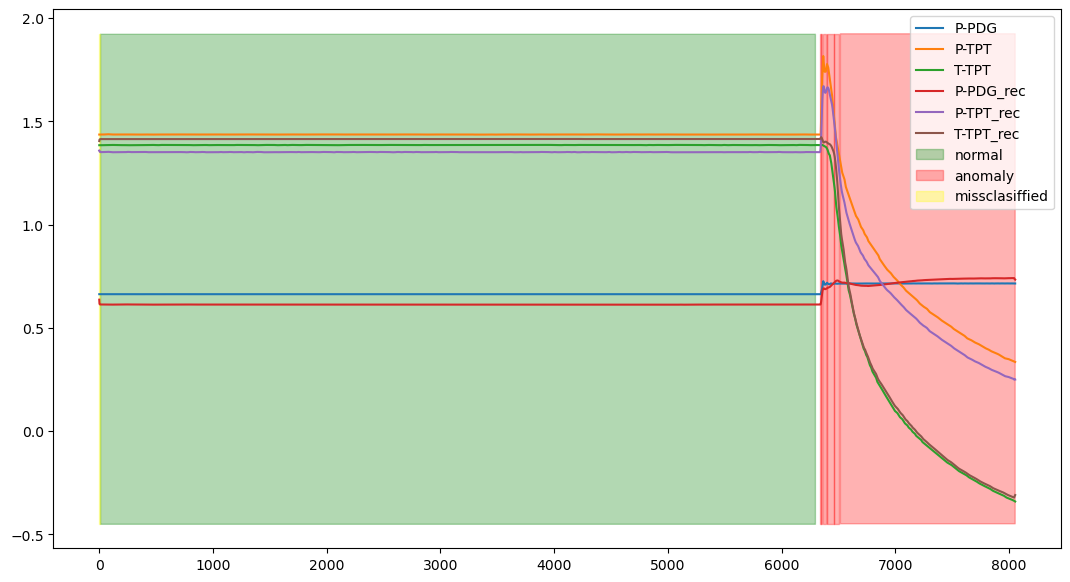

In [133]:
plt.figure(figsize=(13,7))
plt.plot(sample_test_np_scaled)
plt.plot(pred_2d)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin, where=((~sample_test_class.astype(bool)) & (~sample_y_pred)), color='green', alpha=0.3)
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=((sample_test_class.astype(bool)) & (sample_y_pred)), color='red', alpha=0.3)
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=(~sample_test_class.astype(bool) & sample_y_pred ), color='yellow', alpha=0.3)
plt.legend(['P-PDG','P-TPT', 'T-TPT','P-PDG_rec','P-TPT_rec', 'T-TPT_rec','normal','anomaly','missclasiffied'])
plt.show()

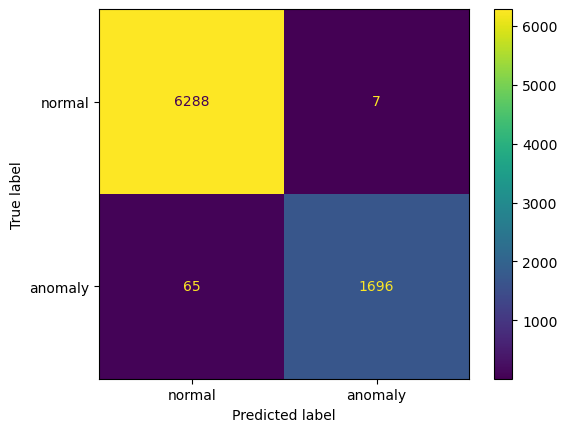

In [134]:
confusion_matrix = metrics.confusion_matrix(np.array(sample_test_class).astype(bool), sample_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'anomaly'])
cm_display.plot()

#### Time Shifted

In [135]:
sample_test['class'] = sample_test[['class']].applymap(lambda x: 0 if x == 0 else 1)
sample_test_shifted = calculate_time_shift(sample_test, 'P-PDG')
sample_test_class_shifted = sample_test_shifted['class']

In [136]:
thres_up, thres_down, f1, sample_y_pred  = find_optimal_threshold(r_e, sample_test_class)
print(thres_up, thres_down, f1)

0.056488629809793245 0.05445857782170871 0.979214780600462


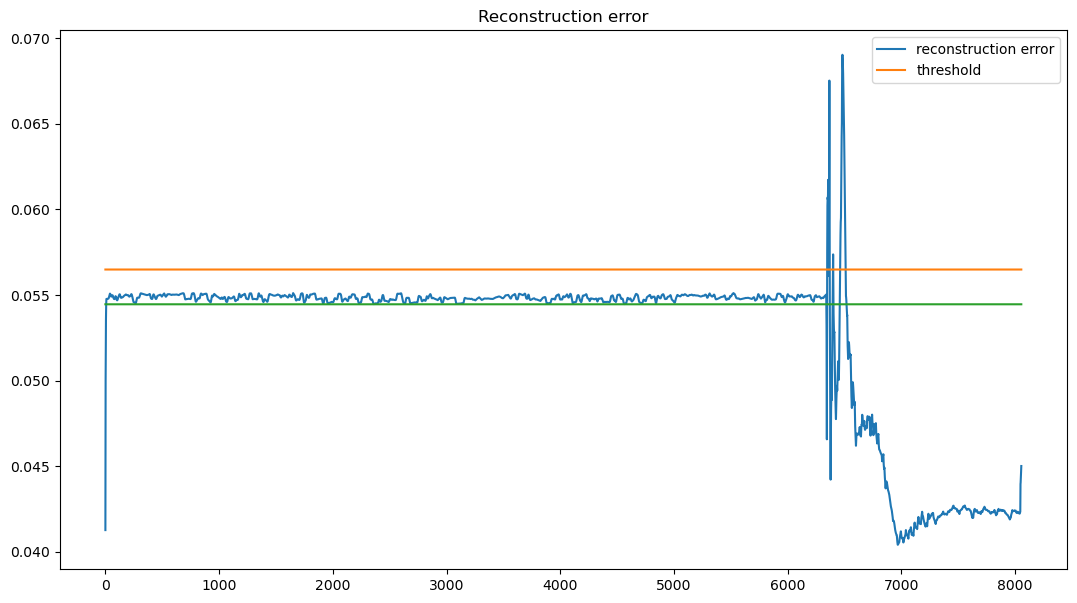

In [137]:
plt.figure(figsize=(13,7))
plt.plot(r_e)
plt.plot(np.full(r_e.shape[0], thres_up))
plt.plot(np.full(r_e.shape[0], thres_down))
plt.title("Reconstruction error")
plt.legend(["reconstruction error", "threshold"])
plt.show()

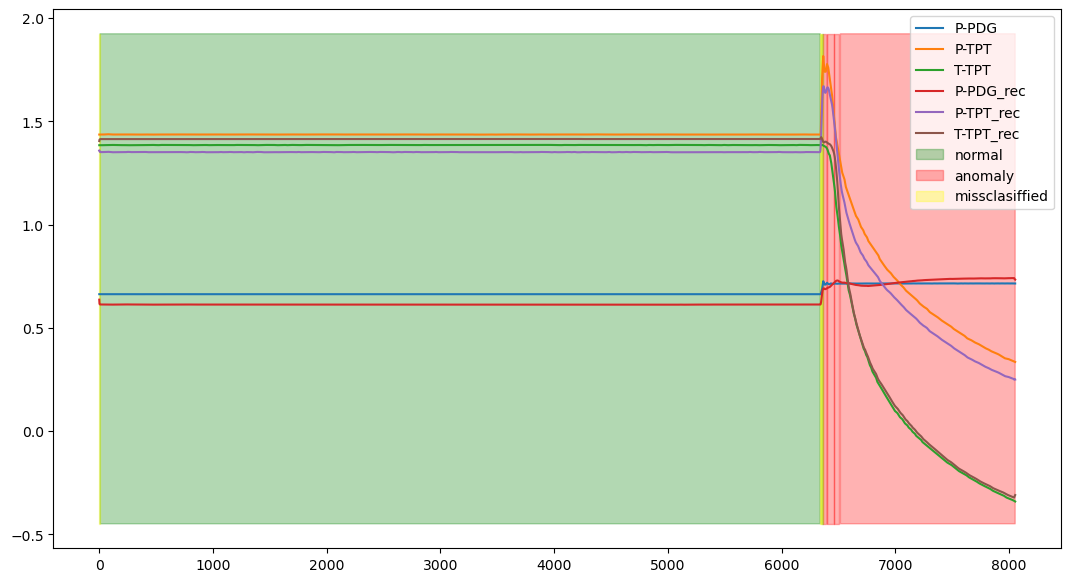

In [138]:
plt.figure(figsize=(13,7))
plt.plot(sample_test_np_scaled)
plt.plot(pred_2d)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin, where=((~sample_test_class_shifted.astype(bool)) & (~sample_y_pred)), color='green', alpha=0.3)
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin, where=((sample_test_class_shifted.astype(bool)) & (sample_y_pred)), color='red', alpha=0.3)
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin, where=(~sample_test_class_shifted.astype(bool) & sample_y_pred ), color='yellow', alpha=0.3)
plt.legend(['P-PDG','P-TPT', 'T-TPT','P-PDG_rec','P-TPT_rec', 'T-TPT_rec','normal','anomaly','missclasiffied'])
plt.show()

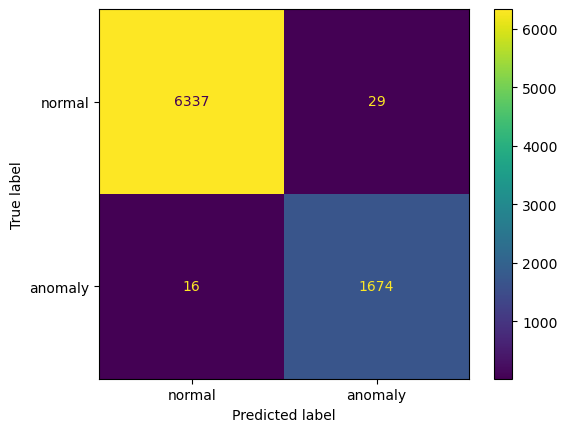

In [139]:
confusion_matrix = metrics.confusion_matrix(np.array(sample_test_class_shifted).astype(bool), sample_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'anomaly'])
cm_display.plot()